In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
def rml_loss_mask_fn(x0_population: torch.Tensor, output_population: torch.Tensor):
    ns_mask = x0_population[..., 0:1] > 0.0
    output_ns = output_population[..., 0:1]
    output_other = output_population[..., 1:]
    return torch.cat([output_ns, 
                      torch.where(ns_mask, output_other, torch.full_like(output_other, fill_value=-1.0))],
                      dim=-1)

In [5]:
def rml_pred_x0_rectify_fn(pred_x0: torch.Tensor):
    ns_mask = pred_x0[..., 0:1] > 0.0
    pred_ns = pred_x0[..., 0:1]
    pred_other = pred_x0[..., 1:]
    return torch.cat([pred_ns, 
                      torch.where(ns_mask, pred_other, torch.full_like(pred_other, fill_value=-1.0))],
                      dim=-1)

In [6]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            out = self.layers(
                torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(2)], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(1)], dim=-1)
        )
        return out.view(x.shape)

In [81]:
device = torch.device("cuda:2")
batch_size = 1024
training_time_steps = 1000
training_iters = 100_000
ddim_steps = 51
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [8]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

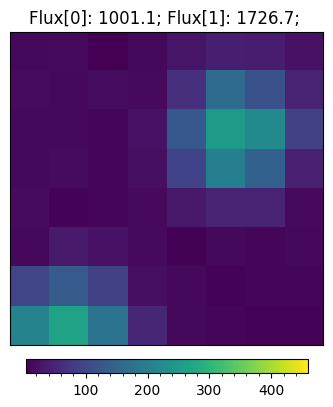

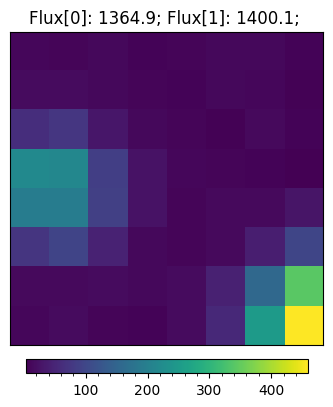

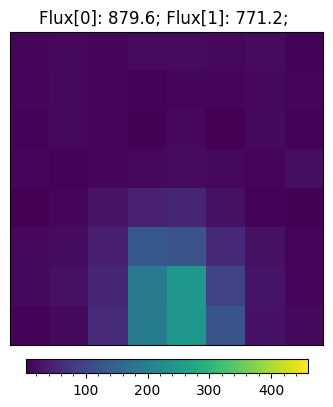

In [9]:
sim_out = image_simulator.generate(3, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [83]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=32,
                                  lambda_=1.0,
                                  beta=1.0,
                                  loss_mask_fn=rml_loss_mask_fn,
                                  pred_x0_rectify_fn=rml_pred_x0_rectify_fn)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [11]:
my_net = FourierMLP(data_shape=[2, 4], 
                    num_layers=8, 
                    hidden_ch=64).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 5 * 4], gamma=0.1)

In [12]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [13]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [14]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    sorted_index = x_start[..., -1].argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [15]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [16]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [17]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    train_loss_args = {
        "model": my_net,
        "x_start": encode_x_start(catalog),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  1%|          | 511/100000 [00:08<29:32, 56.12it/s]

[500/100000] loss: 2.132e-01


  1%|          | 1009/100000 [00:17<32:19, 51.04it/s]

[1000/100000] loss: 1.281e-01


  2%|▏         | 1515/100000 [00:26<21:43, 75.55it/s]

[1500/100000] loss: 8.067e-02


  2%|▏         | 2010/100000 [00:35<23:43, 68.85it/s]

[2000/100000] loss: 6.971e-02


  3%|▎         | 2508/100000 [00:44<25:28, 63.79it/s]

[2500/100000] loss: 6.355e-02


  3%|▎         | 3011/100000 [00:53<23:17, 69.41it/s]

[3000/100000] loss: 5.999e-02


  4%|▎         | 3510/100000 [01:02<27:29, 58.51it/s]

[3500/100000] loss: 5.991e-02


  4%|▍         | 4015/100000 [01:11<24:46, 64.57it/s]

[4000/100000] loss: 4.958e-02


  5%|▍         | 4508/100000 [01:19<26:21, 60.37it/s]

[4500/100000] loss: 5.195e-02


  5%|▌         | 5012/100000 [01:28<21:27, 73.80it/s]

[5000/100000] loss: 5.161e-02


  6%|▌         | 5509/100000 [01:37<25:30, 61.73it/s]

[5500/100000] loss: 4.933e-02


  6%|▌         | 6008/100000 [01:46<30:33, 51.27it/s]

[6000/100000] loss: 4.625e-02


  7%|▋         | 6508/100000 [01:56<31:22, 49.67it/s]

[6500/100000] loss: 4.460e-02


  7%|▋         | 7007/100000 [02:05<30:07, 51.45it/s]

[7000/100000] loss: 4.093e-02


  8%|▊         | 7507/100000 [02:14<28:17, 54.49it/s]

[7500/100000] loss: 3.935e-02


  8%|▊         | 8005/100000 [02:21<22:44, 67.42it/s]

[8000/100000] loss: 4.070e-02


  9%|▊         | 8505/100000 [02:31<32:04, 47.55it/s]

[8500/100000] loss: 3.596e-02


  9%|▉         | 9007/100000 [02:40<29:12, 51.92it/s]

[9000/100000] loss: 3.400e-02


 10%|▉         | 9505/100000 [02:49<27:01, 55.82it/s]

[9500/100000] loss: 3.328e-02


 10%|█         | 10007/100000 [02:58<28:33, 52.52it/s]

[10000/100000] loss: 2.873e-02


 11%|█         | 10507/100000 [03:08<30:21, 49.13it/s]

[10500/100000] loss: 3.205e-02


 11%|█         | 11006/100000 [03:18<31:44, 46.72it/s]

[11000/100000] loss: 2.776e-02


 12%|█▏        | 11509/100000 [03:27<24:53, 59.25it/s]

[11500/100000] loss: 3.015e-02


 12%|█▏        | 12010/100000 [03:36<27:06, 54.08it/s]

[12000/100000] loss: 2.846e-02


 13%|█▎        | 12508/100000 [03:46<26:25, 55.18it/s]

[12500/100000] loss: 2.905e-02


 13%|█▎        | 13009/100000 [03:56<30:13, 47.97it/s]

[13000/100000] loss: 2.663e-02


 14%|█▎        | 13505/100000 [04:05<27:57, 51.56it/s]

[13500/100000] loss: 2.994e-02


 14%|█▍        | 14010/100000 [04:14<22:12, 64.55it/s]

[14000/100000] loss: 2.738e-02


 15%|█▍        | 14508/100000 [04:24<25:56, 54.91it/s]

[14500/100000] loss: 2.743e-02


 15%|█▌        | 15006/100000 [04:33<29:21, 48.26it/s]

[15000/100000] loss: 3.104e-02


 16%|█▌        | 15508/100000 [04:42<29:31, 47.70it/s]

[15500/100000] loss: 2.530e-02


 16%|█▌        | 16015/100000 [04:51<19:26, 72.02it/s]

[16000/100000] loss: 2.193e-02


 17%|█▋        | 16508/100000 [05:00<29:33, 47.08it/s]

[16500/100000] loss: 2.384e-02


 17%|█▋        | 17010/100000 [05:10<23:02, 60.04it/s]

[17000/100000] loss: 2.559e-02


 18%|█▊        | 17515/100000 [05:19<18:37, 73.81it/s]

[17500/100000] loss: 2.333e-02


 18%|█▊        | 18007/100000 [05:28<24:41, 55.33it/s]

[18000/100000] loss: 2.493e-02


 19%|█▊        | 18509/100000 [05:37<25:59, 52.26it/s]

[18500/100000] loss: 2.274e-02


 19%|█▉        | 19009/100000 [05:46<25:18, 53.33it/s]

[19000/100000] loss: 2.496e-02


 20%|█▉        | 19505/100000 [05:54<19:56, 67.25it/s]

[19500/100000] loss: 2.283e-02


 20%|██        | 20005/100000 [06:03<27:34, 48.36it/s]

[20000/100000] loss: 2.319e-02


 21%|██        | 20505/100000 [06:13<22:46, 58.16it/s]

[20500/100000] loss: 2.604e-02


 21%|██        | 21010/100000 [06:23<23:39, 55.66it/s]

[21000/100000] loss: 2.241e-02


 22%|██▏       | 21507/100000 [06:32<26:45, 48.90it/s]

[21500/100000] loss: 2.129e-02


 22%|██▏       | 22010/100000 [06:42<23:59, 54.18it/s]

[22000/100000] loss: 2.307e-02


 23%|██▎       | 22508/100000 [06:50<20:57, 61.61it/s]

[22500/100000] loss: 2.163e-02


 23%|██▎       | 23006/100000 [06:59<23:34, 54.43it/s]

[23000/100000] loss: 2.192e-02


 24%|██▎       | 23511/100000 [07:08<21:03, 60.55it/s]

[23500/100000] loss: 2.343e-02


 24%|██▍       | 24008/100000 [07:16<24:52, 50.93it/s]

[24000/100000] loss: 2.345e-02


 25%|██▍       | 24510/100000 [07:25<24:16, 51.83it/s]

[24500/100000] loss: 1.885e-02


 25%|██▌       | 25008/100000 [07:34<15:32, 80.44it/s]

[25000/100000] loss: 2.213e-02


 26%|██▌       | 25508/100000 [07:43<22:39, 54.80it/s]

[25500/100000] loss: 2.085e-02


 26%|██▌       | 26013/100000 [07:52<18:54, 65.23it/s]

[26000/100000] loss: 2.670e-02


 27%|██▋       | 26512/100000 [08:00<16:13, 75.51it/s]

[26500/100000] loss: 2.203e-02


 27%|██▋       | 27006/100000 [08:09<22:11, 54.80it/s]

[27000/100000] loss: 2.111e-02


 28%|██▊       | 27507/100000 [08:18<24:35, 49.13it/s]

[27500/100000] loss: 2.026e-02


 28%|██▊       | 28008/100000 [08:28<20:16, 59.20it/s]

[28000/100000] loss: 2.187e-02


 29%|██▊       | 28513/100000 [08:38<16:56, 70.36it/s]

[28500/100000] loss: 2.226e-02


 29%|██▉       | 29009/100000 [08:46<22:34, 52.43it/s]

[29000/100000] loss: 1.978e-02


 30%|██▉       | 29514/100000 [08:55<18:52, 62.22it/s]

[29500/100000] loss: 2.142e-02


 30%|███       | 30010/100000 [09:05<21:47, 53.53it/s]

[30000/100000] loss: 1.889e-02


 31%|███       | 30505/100000 [09:14<21:38, 53.52it/s]

[30500/100000] loss: 2.462e-02


 31%|███       | 31009/100000 [09:24<24:39, 46.64it/s]

[31000/100000] loss: 2.030e-02


 32%|███▏      | 31506/100000 [09:33<22:29, 50.76it/s]

[31500/100000] loss: 1.960e-02


 32%|███▏      | 32008/100000 [09:43<20:03, 56.50it/s]

[32000/100000] loss: 2.019e-02


 33%|███▎      | 32509/100000 [09:52<20:29, 54.91it/s]

[32500/100000] loss: 2.318e-02


 33%|███▎      | 33009/100000 [10:01<21:52, 51.04it/s]

[33000/100000] loss: 2.428e-02


 34%|███▎      | 33507/100000 [10:10<20:18, 54.59it/s]

[33500/100000] loss: 1.919e-02


 34%|███▍      | 34006/100000 [10:18<22:50, 48.15it/s]

[34000/100000] loss: 2.414e-02


 35%|███▍      | 34508/100000 [10:27<18:57, 57.60it/s]

[34500/100000] loss: 1.998e-02


 35%|███▌      | 35010/100000 [10:35<19:44, 54.87it/s]

[35000/100000] loss: 2.155e-02


 36%|███▌      | 35505/100000 [10:44<17:36, 61.02it/s]

[35500/100000] loss: 2.186e-02


 36%|███▌      | 36012/100000 [10:53<19:20, 55.13it/s]

[36000/100000] loss: 2.199e-02


 37%|███▋      | 36507/100000 [11:02<19:20, 54.69it/s]

[36500/100000] loss: 2.038e-02


 37%|███▋      | 37012/100000 [11:11<16:29, 63.68it/s]

[37000/100000] loss: 2.012e-02


 38%|███▊      | 37511/100000 [11:19<13:29, 77.20it/s]

[37500/100000] loss: 2.127e-02


 38%|███▊      | 38011/100000 [11:28<17:22, 59.47it/s]

[38000/100000] loss: 2.227e-02


 39%|███▊      | 38504/100000 [11:37<19:55, 51.46it/s]

[38500/100000] loss: 2.120e-02


 39%|███▉      | 39009/100000 [11:46<19:36, 51.84it/s]

[39000/100000] loss: 2.204e-02


 40%|███▉      | 39514/100000 [11:56<16:05, 62.66it/s]

[39500/100000] loss: 1.959e-02


 40%|████      | 40006/100000 [12:05<18:46, 53.26it/s]

[40000/100000] loss: 1.888e-02


 41%|████      | 40508/100000 [12:14<17:02, 58.18it/s]

[40500/100000] loss: 2.041e-02


 41%|████      | 41011/100000 [12:23<16:41, 58.88it/s]

[41000/100000] loss: 1.924e-02


 42%|████▏     | 41511/100000 [12:32<13:54, 70.06it/s]

[41500/100000] loss: 2.112e-02


 42%|████▏     | 42004/100000 [12:41<15:48, 61.16it/s]

[42000/100000] loss: 2.081e-02


 43%|████▎     | 42509/100000 [12:50<16:00, 59.84it/s]

[42500/100000] loss: 2.097e-02


 43%|████▎     | 43007/100000 [12:59<19:11, 49.51it/s]

[43000/100000] loss: 1.873e-02


 44%|████▎     | 43509/100000 [13:08<11:59, 78.56it/s]

[43500/100000] loss: 2.261e-02


 44%|████▍     | 44015/100000 [13:17<12:14, 76.27it/s]

[44000/100000] loss: 1.829e-02


 45%|████▍     | 44506/100000 [13:25<14:53, 62.11it/s]

[44500/100000] loss: 1.948e-02


 45%|████▌     | 45006/100000 [13:34<18:39, 49.13it/s]

[45000/100000] loss: 2.428e-02


 46%|████▌     | 45509/100000 [13:44<18:41, 48.58it/s]

[45500/100000] loss: 2.333e-02


 46%|████▌     | 46006/100000 [13:53<17:26, 51.60it/s]

[46000/100000] loss: 2.288e-02


 47%|████▋     | 46509/100000 [14:02<17:35, 50.68it/s]

[46500/100000] loss: 1.933e-02


 47%|████▋     | 47009/100000 [14:12<17:17, 51.07it/s]

[47000/100000] loss: 2.016e-02


 48%|████▊     | 47509/100000 [14:21<17:15, 50.67it/s]

[47500/100000] loss: 1.787e-02


 48%|████▊     | 48014/100000 [14:30<12:14, 70.80it/s]

[48000/100000] loss: 1.773e-02


 49%|████▊     | 48507/100000 [14:39<16:50, 50.95it/s]

[48500/100000] loss: 1.916e-02


 49%|████▉     | 49006/100000 [14:49<15:52, 53.54it/s]

[49000/100000] loss: 2.173e-02


 50%|████▉     | 49507/100000 [14:58<15:48, 53.24it/s]

[49500/100000] loss: 2.181e-02


 50%|█████     | 50005/100000 [15:07<15:22, 54.21it/s]

[50000/100000] loss: 2.037e-02


 51%|█████     | 50506/100000 [15:16<12:08, 67.94it/s]

[50500/100000] loss: 1.930e-02


 51%|█████     | 51008/100000 [15:26<15:58, 51.10it/s]

[51000/100000] loss: 1.862e-02


 52%|█████▏    | 51508/100000 [15:34<15:18, 52.77it/s]

[51500/100000] loss: 2.125e-02


 52%|█████▏    | 52010/100000 [15:44<15:39, 51.08it/s]

[52000/100000] loss: 2.015e-02


 53%|█████▎    | 52509/100000 [15:53<14:14, 55.58it/s]

[52500/100000] loss: 2.041e-02


 53%|█████▎    | 53012/100000 [16:02<13:24, 58.44it/s]

[53000/100000] loss: 2.037e-02


 54%|█████▎    | 53507/100000 [16:12<15:32, 49.87it/s]

[53500/100000] loss: 2.208e-02


 54%|█████▍    | 54005/100000 [16:21<15:16, 50.18it/s]

[54000/100000] loss: 1.913e-02


 55%|█████▍    | 54508/100000 [16:31<14:22, 52.73it/s]

[54500/100000] loss: 1.967e-02


 55%|█████▌    | 55005/100000 [16:40<13:38, 54.94it/s]

[55000/100000] loss: 1.874e-02


 56%|█████▌    | 55506/100000 [16:49<15:24, 48.12it/s]

[55500/100000] loss: 1.881e-02


 56%|█████▌    | 56006/100000 [16:58<14:26, 50.75it/s]

[56000/100000] loss: 2.050e-02


 57%|█████▋    | 56508/100000 [17:08<14:20, 50.55it/s]

[56500/100000] loss: 1.923e-02


 57%|█████▋    | 57010/100000 [17:17<09:17, 77.05it/s]

[57000/100000] loss: 2.041e-02


 58%|█████▊    | 57508/100000 [17:26<14:15, 49.67it/s]

[57500/100000] loss: 1.930e-02


 58%|█████▊    | 58005/100000 [17:36<12:50, 54.48it/s]

[58000/100000] loss: 1.702e-02


 59%|█████▊    | 58515/100000 [17:43<08:54, 77.56it/s]

[58500/100000] loss: 2.217e-02


 59%|█████▉    | 59005/100000 [17:50<11:38, 58.68it/s]

[59000/100000] loss: 1.701e-02


 60%|█████▉    | 59505/100000 [17:59<13:07, 51.40it/s]

[59500/100000] loss: 1.839e-02


 60%|██████    | 60005/100000 [18:08<13:49, 48.20it/s]

[60000/100000] loss: 1.921e-02


 61%|██████    | 60505/100000 [18:17<12:10, 54.07it/s]

[60500/100000] loss: 1.772e-02


 61%|██████    | 61010/100000 [18:27<12:45, 50.93it/s]

[61000/100000] loss: 1.939e-02


 62%|██████▏   | 61508/100000 [18:36<12:16, 52.27it/s]

[61500/100000] loss: 1.933e-02


 62%|██████▏   | 62007/100000 [18:46<12:42, 49.83it/s]

[62000/100000] loss: 1.868e-02


 63%|██████▎   | 62504/100000 [18:55<11:22, 54.95it/s]

[62500/100000] loss: 1.877e-02


 63%|██████▎   | 63007/100000 [19:05<11:04, 55.63it/s]

[63000/100000] loss: 1.824e-02


 64%|██████▎   | 63509/100000 [19:14<12:24, 49.00it/s]

[63500/100000] loss: 1.707e-02


 64%|██████▍   | 64004/100000 [19:25<11:53, 50.48it/s]

[64000/100000] loss: 1.797e-02


 65%|██████▍   | 64510/100000 [19:34<12:00, 49.27it/s]

[64500/100000] loss: 2.048e-02


 65%|██████▌   | 65006/100000 [19:43<09:06, 64.09it/s]

[65000/100000] loss: 1.798e-02


 66%|██████▌   | 65513/100000 [19:52<09:07, 62.95it/s]

[65500/100000] loss: 1.897e-02


 66%|██████▌   | 66010/100000 [20:00<10:16, 55.17it/s]

[66000/100000] loss: 1.715e-02


 67%|██████▋   | 66507/100000 [20:09<11:13, 49.74it/s]

[66500/100000] loss: 2.014e-02


 67%|██████▋   | 67008/100000 [20:18<07:01, 78.21it/s]

[67000/100000] loss: 1.768e-02


 68%|██████▊   | 67507/100000 [20:25<10:05, 53.70it/s]

[67500/100000] loss: 1.955e-02


 68%|██████▊   | 68007/100000 [20:34<10:19, 51.61it/s]

[68000/100000] loss: 1.653e-02


 69%|██████▊   | 68515/100000 [20:41<06:34, 79.88it/s]

[68500/100000] loss: 2.113e-02


 69%|██████▉   | 69013/100000 [20:47<07:52, 65.58it/s]

[69000/100000] loss: 1.815e-02


 70%|██████▉   | 69508/100000 [20:57<08:24, 60.47it/s]

[69500/100000] loss: 1.700e-02


 70%|███████   | 70008/100000 [21:06<10:10, 49.12it/s]

[70000/100000] loss: 1.895e-02


 71%|███████   | 70509/100000 [21:15<08:56, 54.95it/s]

[70500/100000] loss: 1.981e-02


 71%|███████   | 71010/100000 [21:25<09:30, 50.82it/s]

[71000/100000] loss: 1.884e-02


 72%|███████▏  | 71507/100000 [21:34<09:14, 51.40it/s]

[71500/100000] loss: 1.996e-02


 72%|███████▏  | 72010/100000 [21:44<08:53, 52.47it/s]

[72000/100000] loss: 1.763e-02


 73%|███████▎  | 72512/100000 [21:53<06:47, 67.45it/s]

[72500/100000] loss: 1.695e-02


 73%|███████▎  | 73005/100000 [22:02<08:09, 55.16it/s]

[73000/100000] loss: 1.884e-02


 74%|███████▎  | 73506/100000 [22:11<08:47, 50.18it/s]

[73500/100000] loss: 2.018e-02


 74%|███████▍  | 74010/100000 [22:19<08:24, 51.47it/s]

[74000/100000] loss: 1.908e-02


 75%|███████▍  | 74507/100000 [22:28<08:08, 52.22it/s]

[74500/100000] loss: 1.880e-02


 75%|███████▌  | 75008/100000 [22:37<06:49, 61.02it/s]

[75000/100000] loss: 1.920e-02


 76%|███████▌  | 75508/100000 [22:46<08:08, 50.16it/s]

[75500/100000] loss: 2.114e-02


 76%|███████▌  | 76007/100000 [22:56<07:41, 51.98it/s]

[76000/100000] loss: 2.161e-02


 77%|███████▋  | 76505/100000 [23:05<07:03, 55.44it/s]

[76500/100000] loss: 1.812e-02


 77%|███████▋  | 77010/100000 [23:13<06:45, 56.75it/s]

[77000/100000] loss: 1.861e-02


 78%|███████▊  | 77517/100000 [23:22<04:28, 83.80it/s]

[77500/100000] loss: 1.907e-02


 78%|███████▊  | 78013/100000 [23:30<05:29, 66.70it/s]

[78000/100000] loss: 1.952e-02


 79%|███████▊  | 78508/100000 [23:39<07:38, 46.89it/s]

[78500/100000] loss: 2.160e-02


 79%|███████▉  | 79012/100000 [23:48<06:02, 57.91it/s]

[79000/100000] loss: 1.696e-02


 80%|███████▉  | 79510/100000 [23:57<06:04, 56.18it/s]

[79500/100000] loss: 1.712e-02


 80%|████████  | 80010/100000 [24:06<06:02, 55.19it/s]

[80000/100000] loss: 1.886e-02


 81%|████████  | 80509/100000 [24:15<06:13, 52.21it/s]

[80500/100000] loss: 1.679e-02


 81%|████████  | 81012/100000 [24:24<04:08, 76.37it/s]

[81000/100000] loss: 1.847e-02


 82%|████████▏ | 81509/100000 [24:33<06:02, 51.06it/s]

[81500/100000] loss: 1.654e-02


 82%|████████▏ | 82011/100000 [24:42<04:58, 60.23it/s]

[82000/100000] loss: 1.829e-02


 83%|████████▎ | 82507/100000 [24:51<05:41, 51.17it/s]

[82500/100000] loss: 1.702e-02


 83%|████████▎ | 83005/100000 [24:59<04:51, 58.21it/s]

[83000/100000] loss: 1.679e-02


 84%|████████▎ | 83514/100000 [25:08<03:37, 75.70it/s]

[83500/100000] loss: 1.620e-02


 84%|████████▍ | 84009/100000 [25:16<03:54, 68.32it/s]

[84000/100000] loss: 1.796e-02


 85%|████████▍ | 84515/100000 [25:24<03:25, 75.36it/s]

[84500/100000] loss: 1.721e-02


 85%|████████▌ | 85008/100000 [25:32<04:20, 57.50it/s]

[85000/100000] loss: 1.814e-02


 86%|████████▌ | 85510/100000 [25:42<04:46, 50.58it/s]

[85500/100000] loss: 1.591e-02


 86%|████████▌ | 86009/100000 [25:52<04:55, 47.29it/s]

[86000/100000] loss: 1.610e-02


 87%|████████▋ | 86504/100000 [26:01<03:34, 62.97it/s]

[86500/100000] loss: 1.889e-02


 87%|████████▋ | 87005/100000 [26:09<04:27, 48.67it/s]

[87000/100000] loss: 1.768e-02


 88%|████████▊ | 87514/100000 [26:16<02:48, 74.29it/s]

[87500/100000] loss: 1.717e-02


 88%|████████▊ | 88006/100000 [26:25<03:28, 57.59it/s]

[88000/100000] loss: 1.986e-02


 89%|████████▊ | 88507/100000 [26:34<03:51, 49.66it/s]

[88500/100000] loss: 1.819e-02


 89%|████████▉ | 89006/100000 [26:43<03:29, 52.50it/s]

[89000/100000] loss: 1.843e-02


 90%|████████▉ | 89507/100000 [26:53<03:23, 51.58it/s]

[89500/100000] loss: 1.684e-02


 90%|█████████ | 90006/100000 [27:01<03:13, 51.69it/s]

[90000/100000] loss: 1.529e-02


 91%|█████████ | 90510/100000 [27:10<03:06, 50.84it/s]

[90500/100000] loss: 1.578e-02


 91%|█████████ | 91006/100000 [27:19<03:04, 48.87it/s]

[91000/100000] loss: 1.626e-02


 92%|█████████▏| 91507/100000 [27:28<01:59, 71.34it/s]

[91500/100000] loss: 1.856e-02


 92%|█████████▏| 92011/100000 [27:37<01:52, 70.84it/s]

[92000/100000] loss: 1.646e-02


 93%|█████████▎| 92511/100000 [27:47<02:21, 52.74it/s]

[92500/100000] loss: 1.860e-02


 93%|█████████▎| 93011/100000 [27:55<01:55, 60.26it/s]

[93000/100000] loss: 1.891e-02


 94%|█████████▎| 93508/100000 [28:04<01:36, 67.08it/s]

[93500/100000] loss: 1.967e-02


 94%|█████████▍| 94007/100000 [28:13<01:56, 51.26it/s]

[94000/100000] loss: 2.046e-02


 95%|█████████▍| 94512/100000 [28:22<01:12, 75.48it/s]

[94500/100000] loss: 1.549e-02


 95%|█████████▌| 95006/100000 [28:30<01:31, 54.35it/s]

[95000/100000] loss: 1.931e-02


 96%|█████████▌| 95511/100000 [28:40<01:14, 60.26it/s]

[95500/100000] loss: 1.564e-02


 96%|█████████▌| 96012/100000 [28:48<01:05, 60.96it/s]

[96000/100000] loss: 1.614e-02


 97%|█████████▋| 96510/100000 [28:57<01:05, 53.05it/s]

[96500/100000] loss: 1.797e-02


 97%|█████████▋| 97009/100000 [29:07<00:59, 50.60it/s]

[97000/100000] loss: 1.836e-02


 98%|█████████▊| 97510/100000 [29:17<00:44, 55.65it/s]

[97500/100000] loss: 1.759e-02


 98%|█████████▊| 98005/100000 [29:26<00:39, 50.78it/s]

[98000/100000] loss: 1.563e-02


 99%|█████████▊| 98510/100000 [29:35<00:28, 51.93it/s]

[98500/100000] loss: 1.703e-02


 99%|█████████▉| 99008/100000 [29:44<00:19, 50.07it/s]

[99000/100000] loss: 1.899e-02


100%|█████████▉| 99506/100000 [29:54<00:09, 50.53it/s]

[99500/100000] loss: 1.827e-02


100%|██████████| 100000/100000 [30:02<00:00, 55.48it/s]

[100000/100000] loss: 1.392e-02


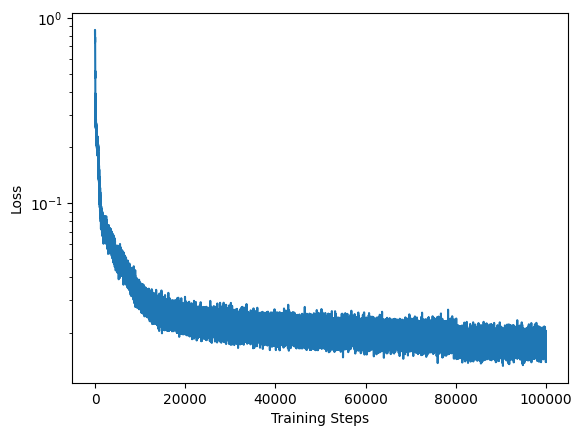

In [18]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [84]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(1000))):
        val_catalog = image_simulator.generate(batch_size=1024)
        input_image = normalize_image(val_catalog["images"])
        val_catalog = decode_x_start(encode_x_start(val_catalog))
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(decode_x_start(sample), "cpu"))

100%|██████████| 1000/1000 [02:25<00:00,  6.85it/s]


In [85]:
diffusion_pred_ns = []
diffusion_true_ns = []
diffusion_pred_locs = []
diffusion_true_locs = []
diffusion_pred_fluxes = []
diffusion_true_fluxes = []
for ec, tc in zip(val_est_cat, val_true_cat, strict=True):
    diffusion_pred_ns.append(ec["n_sources"])
    diffusion_true_ns.append(tc["n_sources"])
    diffusion_pred_locs.append(ec["locs"])
    diffusion_true_locs.append(tc["locs"])
    diffusion_pred_fluxes.append(ec["fluxes"])
    diffusion_true_fluxes.append(tc["fluxes"])
diffusion_pred_ns = torch.cat(diffusion_pred_ns, dim=0)
diffusion_true_ns = torch.cat(diffusion_true_ns, dim=0)
diffusion_pred_locs = torch.cat(diffusion_pred_locs, dim=0)
diffusion_true_locs = torch.cat(diffusion_true_locs, dim=0)
diffusion_pred_fluxes = torch.cat(diffusion_pred_fluxes, dim=0)
diffusion_true_fluxes = torch.cat(diffusion_true_fluxes, dim=0)

In [98]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [87]:
diffusion_pred_locs.shape, diffusion_true_locs.shape

(torch.Size([1024000, 2, 2]), torch.Size([1024000, 2, 2]))

In [88]:
diffusion_pred_fluxes.shape, diffusion_true_fluxes.shape

(torch.Size([1024000, 2]), torch.Size([1024000, 2]))

In [89]:
def plot_cm(d_pred_bin_index, d_true_bin_index, bin_num, bin_labels, axis_label):
    d_cm = torch.zeros(bin_num, bin_num, dtype=torch.int)
    for ri in range(d_cm.shape[0]):
        for ci in range(d_cm.shape[1]):
            d_cm[ri, ci] = ((d_pred_bin_index == ri) & (d_true_bin_index == ci)).sum()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(d_cm,
                annot=True,
                fmt="d", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion")
    fig.show()

    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
    #             annot=True,
    #             fmt=".2f", cmap="Greens", cbar=False,
    #             xticklabels=bin_labels,
    #             yticklabels=bin_labels,
    #             ax=ax)
    # ax.set_xlabel(f"True {axis_label}")
    # ax.set_ylabel(f"Pred {axis_label}")
    # ax.set_title("Diffusion (CM in Percent)")
    # fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.heatmap(((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1)).abs(),
                annot=(d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
                fmt=".2f", cmap="Greens", cbar=False,
                xticklabels=bin_labels,
                yticklabels=bin_labels,
                ax=ax)
    ax.set_xlabel(f"True {axis_label}")
    ax.set_ylabel(f"Pred {axis_label}")
    ax.set_title("Diffusion (Asymmetry Factor)")
    fig.show()

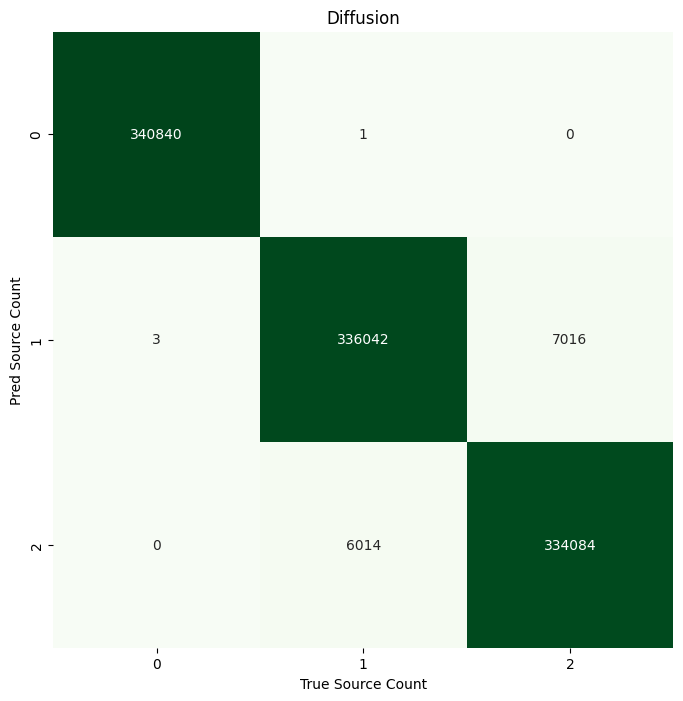

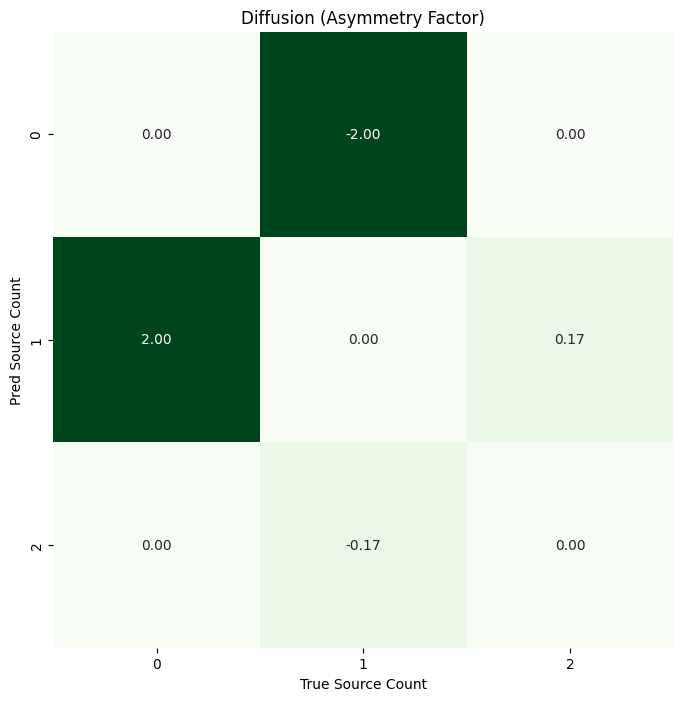

In [90]:
plot_cm(diffusion_pred_ns.sum(dim=-1), diffusion_true_ns.sum(dim=-1), 
        bin_num=3, bin_labels=list(range(3)), axis_label="Source Count")

In [91]:
def inclusive_bucektize(input_t, boundary):
    new_boundary = boundary.clone()
    new_boundary[0] -= 1e-3
    new_boundary[-1] += 1e-3
    b_index = torch.bucketize(input_t, new_boundary)
    assert (b_index > 0).all()
    assert (b_index < new_boundary.shape[0]).all()
    return b_index - 1

In [102]:
valid_source_mask = diffusion_pred_ns.bool() & \
      (diffusion_pred_ns.sum(dim=-1) == diffusion_true_ns.sum(dim=-1)).unsqueeze(-1)

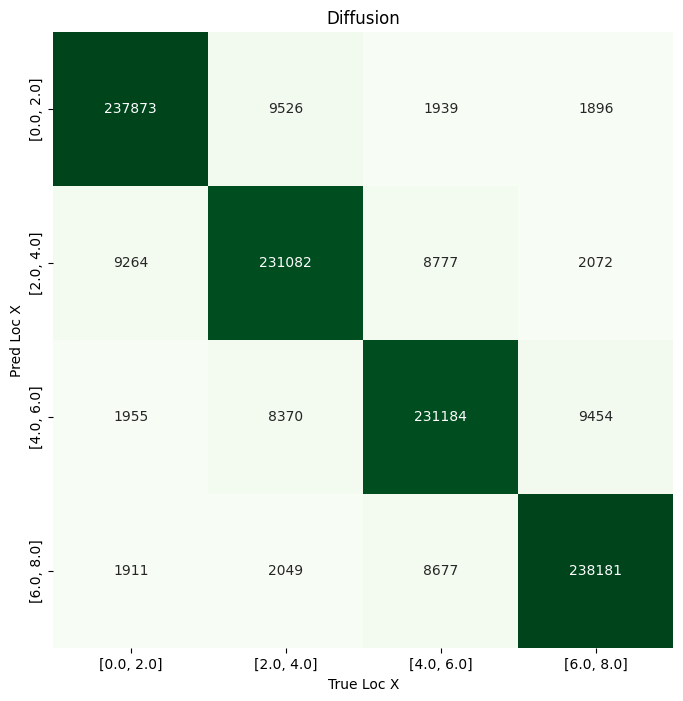

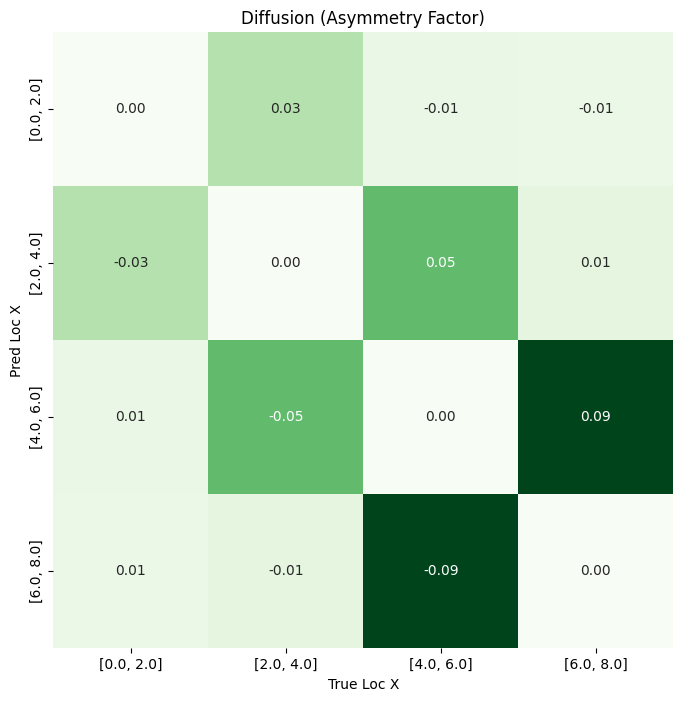

In [110]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[valid_source_mask][:, 1], locs_bin_boundary)
d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[valid_source_mask][:, 1], locs_bin_boundary)
plot_cm(d_pred_locs_x_bin_index, d_true_locs_x_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc X")

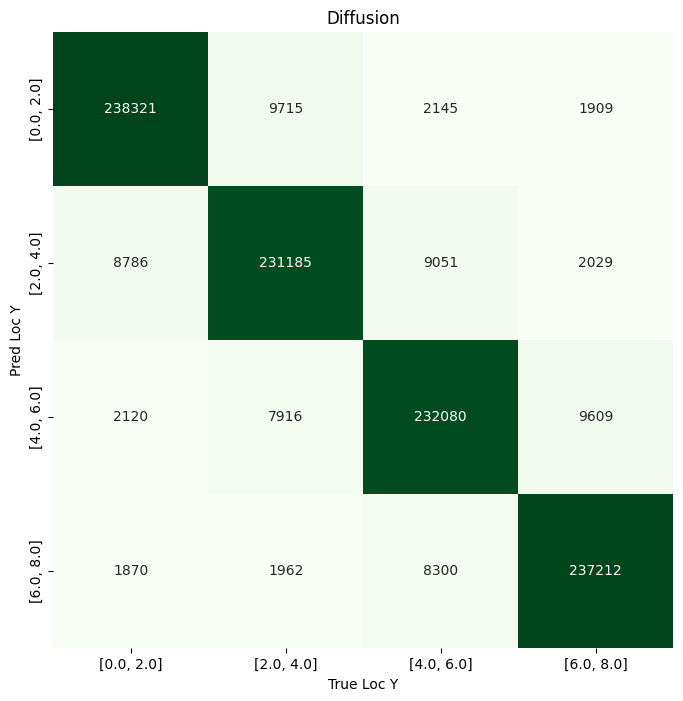

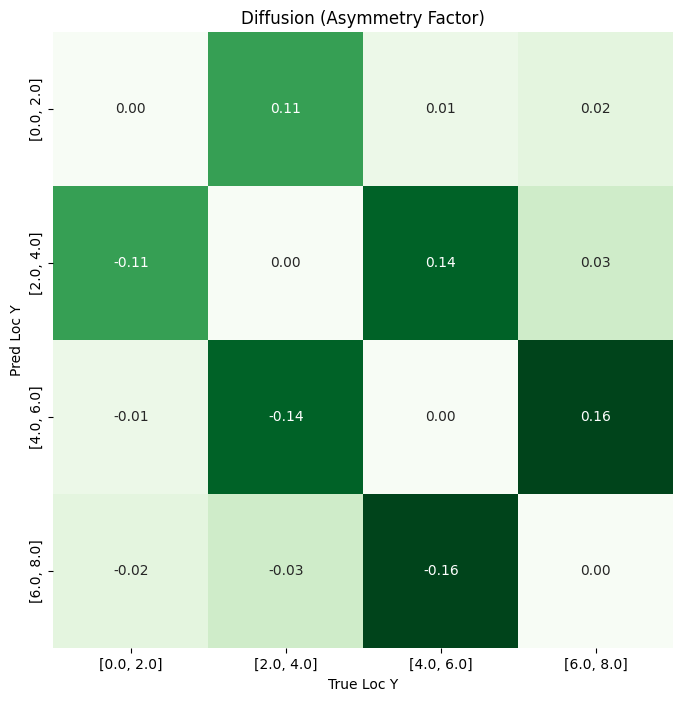

In [113]:
locs_bin_boundary = torch.linspace(0.0, 8.0, 5)
d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[valid_source_mask][:, 0], locs_bin_boundary)
d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[valid_source_mask][:, 0], locs_bin_boundary)
plot_cm(d_pred_locs_y_bin_index, d_true_locs_y_bin_index, 
        bin_num=4, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(locs_bin_boundary[:-1], 
                                                   locs_bin_boundary[1:])], 
        axis_label="Loc Y")

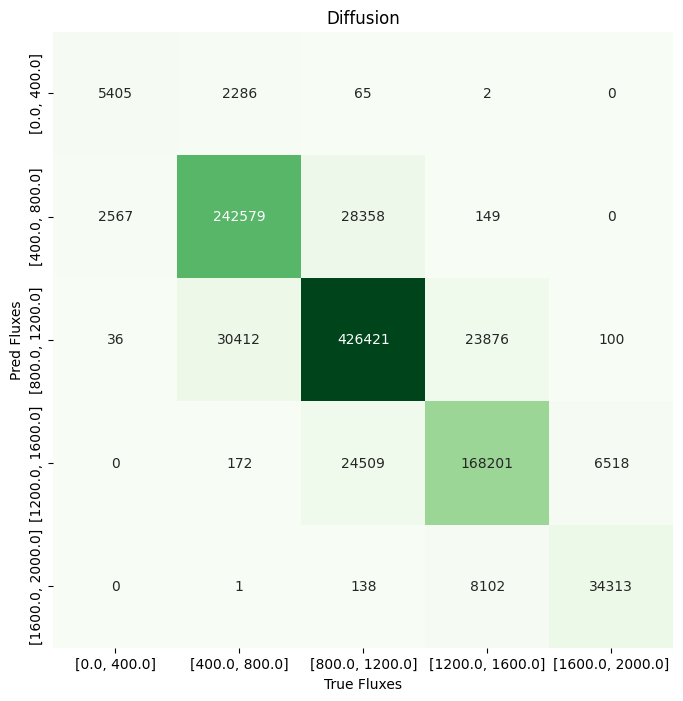

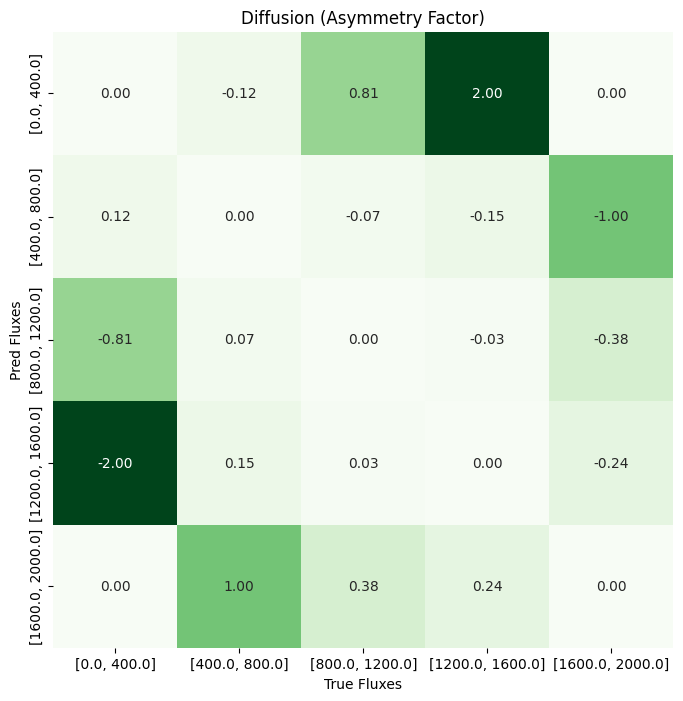

In [115]:
fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 6)
d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes[valid_source_mask], fluxes_bin_boundary)
d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes[valid_source_mask], fluxes_bin_boundary)
plot_cm(d_pred_fluxes_bin_index, d_true_fluxes_bin_index, 
        bin_num=5, bin_labels=[f"[{bl1:.1f}, {bl2:.1f}]" 
                               for bl1, bl2 in zip(fluxes_bin_boundary[:-1], 
                                                   fluxes_bin_boundary[1:])], 
        axis_label="Fluxes")

In [95]:
# d_pred_ns_bin_index = repeat(diffusion_pred_ns.sum(dim=-1), "b -> b m", m=max_objects)
# d_true_ns_bin_index = repeat(diffusion_true_ns.sum(dim=-1), "b -> b m", m=max_objects)
# locs_bin_boundary = torch.linspace(0.0, 8.0, 3)
# d_pred_locs_x_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 1], locs_bin_boundary)
# d_true_locs_x_bin_index = inclusive_bucektize(diffusion_true_locs[..., 1], locs_bin_boundary)
# d_pred_locs_y_bin_index = inclusive_bucektize(diffusion_pred_locs[..., 0], locs_bin_boundary)
# d_true_locs_y_bin_index = inclusive_bucektize(diffusion_true_locs[..., 0], locs_bin_boundary)
# fluxes_bin_boundary = torch.linspace(0.0, 2000.0, 3)
# d_pred_fluxes_bin_index = inclusive_bucektize(diffusion_pred_fluxes, fluxes_bin_boundary)
# d_true_fluxes_bin_index = inclusive_bucektize(diffusion_true_fluxes, fluxes_bin_boundary)

In [96]:
# d_pred_mix_bin_index = torch.stack([d_pred_ns_bin_index,
#                                     d_pred_locs_x_bin_index,
#                                     d_pred_locs_y_bin_index,
#                                     d_pred_fluxes_bin_index], dim=-1)  # (b, m, 4)
# d_true_mix_bin_index = torch.stack([d_true_ns_bin_index,
#                                     d_true_locs_x_bin_index,
#                                     d_true_locs_y_bin_index,
#                                     d_true_fluxes_bin_index], dim=-1)

In [97]:
# d_pred_mix_bin_index.shape, d_true_mix_bin_index.shape